In [73]:
import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from corner import corner
from acor import acor

import healpy as hp
from astropy.time import Time

from matplotlib.colors import LogNorm

%matplotlib inline

def trace_plot(chain, pars,
               cols=3, wid_per_col=4, aspect=4/3,
               kwargs={}):

    rows = len(pars)//cols
    if rows*cols < len(pars):
        rows += 1

    ax = []
    width = wid_per_col * cols
    height = wid_per_col * rows / aspect
    fig = plt.figure(figsize=(width, height))

    for pp, par in enumerate(pars):
        ax.append(fig.add_subplot(rows, cols, pp+1))
        ax[pp].plot(chain[:,pp], **kwargs)
        ax[pp].set_xlabel(par)
    plt.tight_layout()
    return fig


def hist_plot(chain, pars, bins=30,
              cols=3, wid_per_col=4, aspect=4/3,
              kwargs={}):
    hist_kwargs = {
        'density':True,
        'histtype':'step',
    }
    for key, val in kwargs.items():
        hist_kwargs[key] = val

    rows = len(pars)//cols
    if rows*cols < len(pars):
        rows += 1

    ax = []
    width = wid_per_col * cols
    height = wid_per_col * rows / aspect
    fig = plt.figure(figsize=(width, height))

    for pp, par in enumerate(pars):
        ax.append(fig.add_subplot(rows, cols, pp+1))
        ax[pp].hist(chain[:,pp], bins=bins, **hist_kwargs)
        ax[pp].set_xlabel(par)
    plt.tight_layout()
    return fig

def UL_subsamp(chain, p=0.95, Ntrial=20):
    UL_full = np.percentile(chain, 100*p)  # 95 for 95% (not 0.95)
    Nsamp = len(chain) // Ntrial
    ULs = []
    for ii in range(Ntrial):
        resamp = np.random.choice(chain, size=Nsamp)
        ULs.append(np.percentile(resamp, 100*p))
    dUL = np.std(ULs)

    return UL_full, dUL

In [3]:
Nts = 40  # number of time bins
TMIN = 53217.0
TMAX = 57387.0
Ts_all = np.linspace(TMIN, TMAX, Nts+2)[1:-1]  # don't use first/last t0

In [4]:
sky = 4
Ts = Ts_all

t0 = Ts[4]
rundir = '/home/pbaker/nanograv/bwm/ULvT/DE436_BE/56064.80/{:02d}/1.18/'.format(sky)
#rundir = '/home/pbaker/nanograv/bwm/ULvT/DE436/{:.2f}/{:02d}/1.18/'.format(t0, sky)
#rundir = '/home/pbaker/nanograv/bwm/ULvT/test/'
#rundir = '/home/pbaker/nanograv/bwm/ULvT/test_BE/'
#rundir = '/home/pbaker/nanograv/bwm/ULvT/py3_test/'

nside=2
theta, phi = hp.pix2ang(nside, sky)
costh = np.cos(theta)
print("costh = {:.2f}, phi = {:.2f}".format(costh, phi))


costh = 0.67, phi = 0.39


In [5]:
with open(rundir + 'params.txt', 'r') as f:
    params = [line.rstrip('\n') for line in f]

# get just bwm params
par_BE = []
idx_BE = []
for par in params:
    if par.startswith('jup_') or par.startswith('d_') or 'drift' in par:
        par_BE.append(par)
        idx_BE.append(params.index(par))
idx_A = params.index('bwm_log10_A')

In [6]:
chain_raw = pd.read_csv(rundir + 'chain_1.txt',
                        sep='\t', dtype=float, header=None).values
print(len(chain_raw))

490


In [7]:
burnfrac = 0.10
thin = 1

burn = int(burnfrac * len(chain_raw))
chain = chain_raw[burn::thin]

ch_A = chain[:,idx_A]
ch_L = chain[:,-4]
ch_BE = chain[:, idx_BE]

corL = acor(ch_A)[0]
N = len(ch_A)
print("N = {}, corL = {}".format(N, corL))

N = 441, corL = 2.8937851348134926


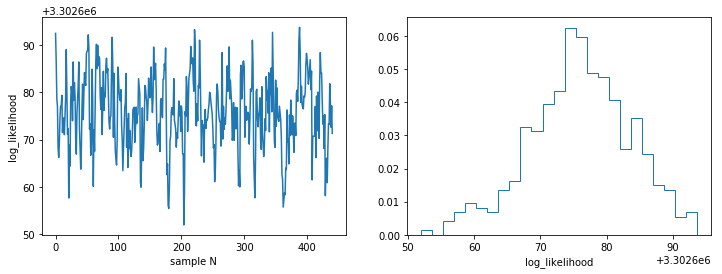

In [8]:
fig = plt.figure(figsize=(12,4))

ax1 = fig.add_subplot(121)
ax1.plot(ch_L)
ax1.set_ylabel('log_likelihood')
ax1.set_xlabel('sample N')

ax2 = fig.add_subplot(122)
ax2.hist(ch_L, bins=25, density=True, histtype='step')
ax2.set_xlabel('log_likelihood');

UL: 2.484 +/- 0.362 x 10^-14


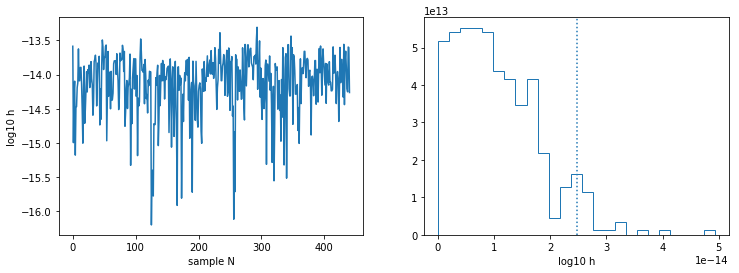

In [9]:
UL, dUL = UL_subsamp(10**ch_A)
print('UL: {:.3f} +/- {:.3f} x 10^-14'.format(UL*1e14, dUL*1e14))

fig = plt.figure(figsize=(12,4))

ax1 = fig.add_subplot(121)
ax1.plot(ch_A)
ax1.set_ylabel('log10 h')
ax1.set_xlabel('sample N')

ax2 = fig.add_subplot(122)
ax2.hist(10**ch_A, bins=25, density=True, histtype='step')
ax2.axvline(x=UL, ls=':')
ax2.set_xlabel('log10 h');

In [10]:
par_jup = []
idx_jup = []
for par in params:
    if par.startswith('jup_'):
        par_jup.append(par)
        idx_jup.append(params.index(par))

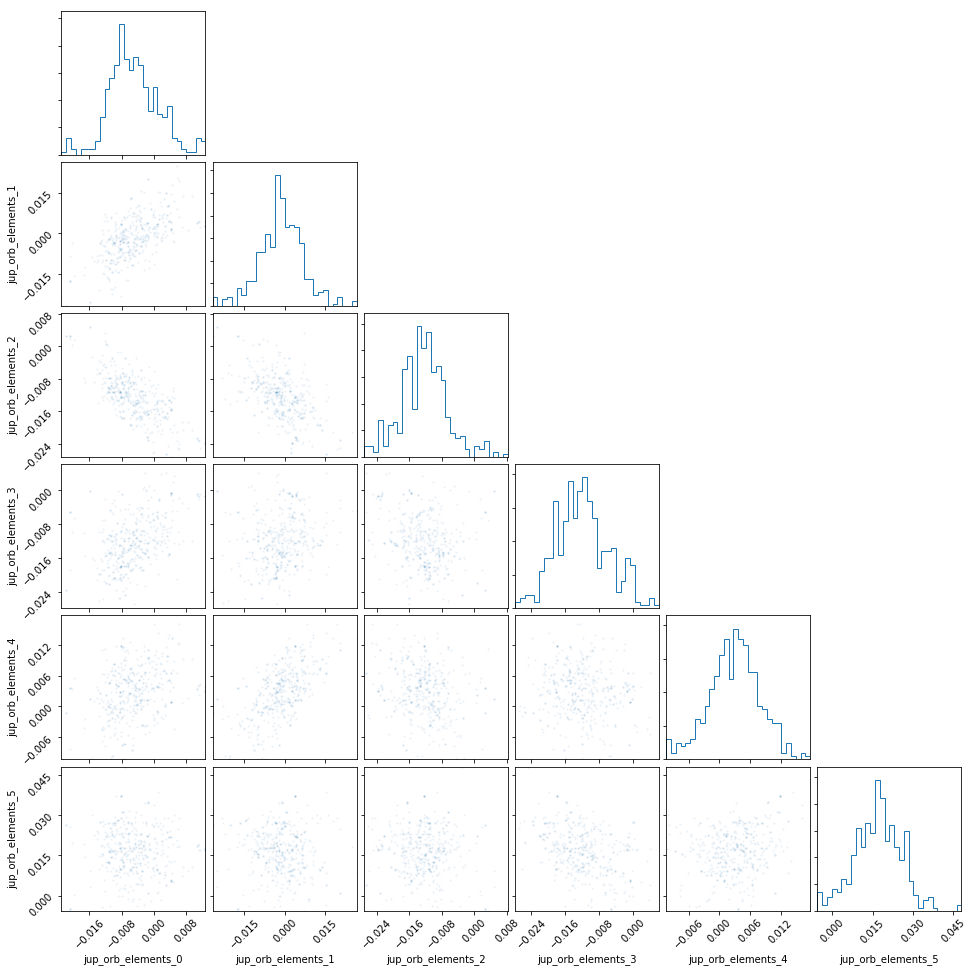

In [11]:
corner_kwargs = {'bins':30,
                 'show_titles':False,
                 'labels':par_jup,
                 'smooth':0.25,
                 'plot_datapoints':True,
                 'plot_density':False,
                 'plot_contours':False,
                 'fill_contours':False,}

fig = corner(chain[:,idx_jup], color='C0', **corner_kwargs);

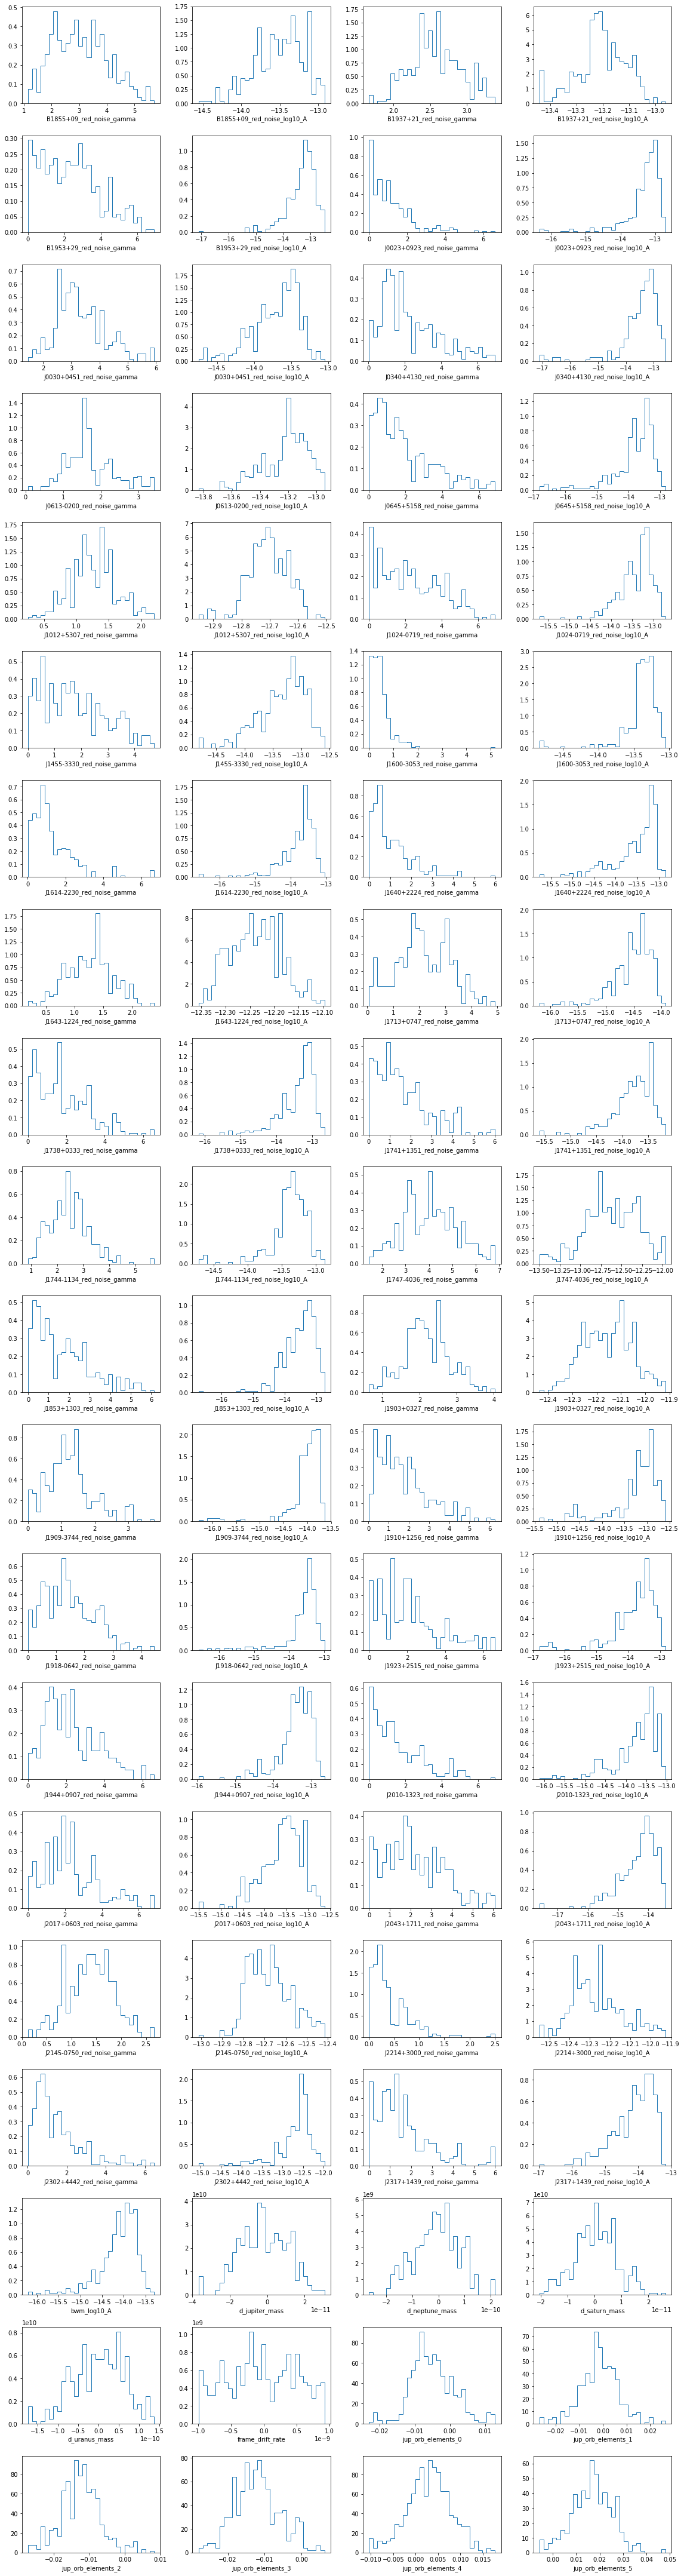

In [12]:
hist_plot(chain, params, cols=4);

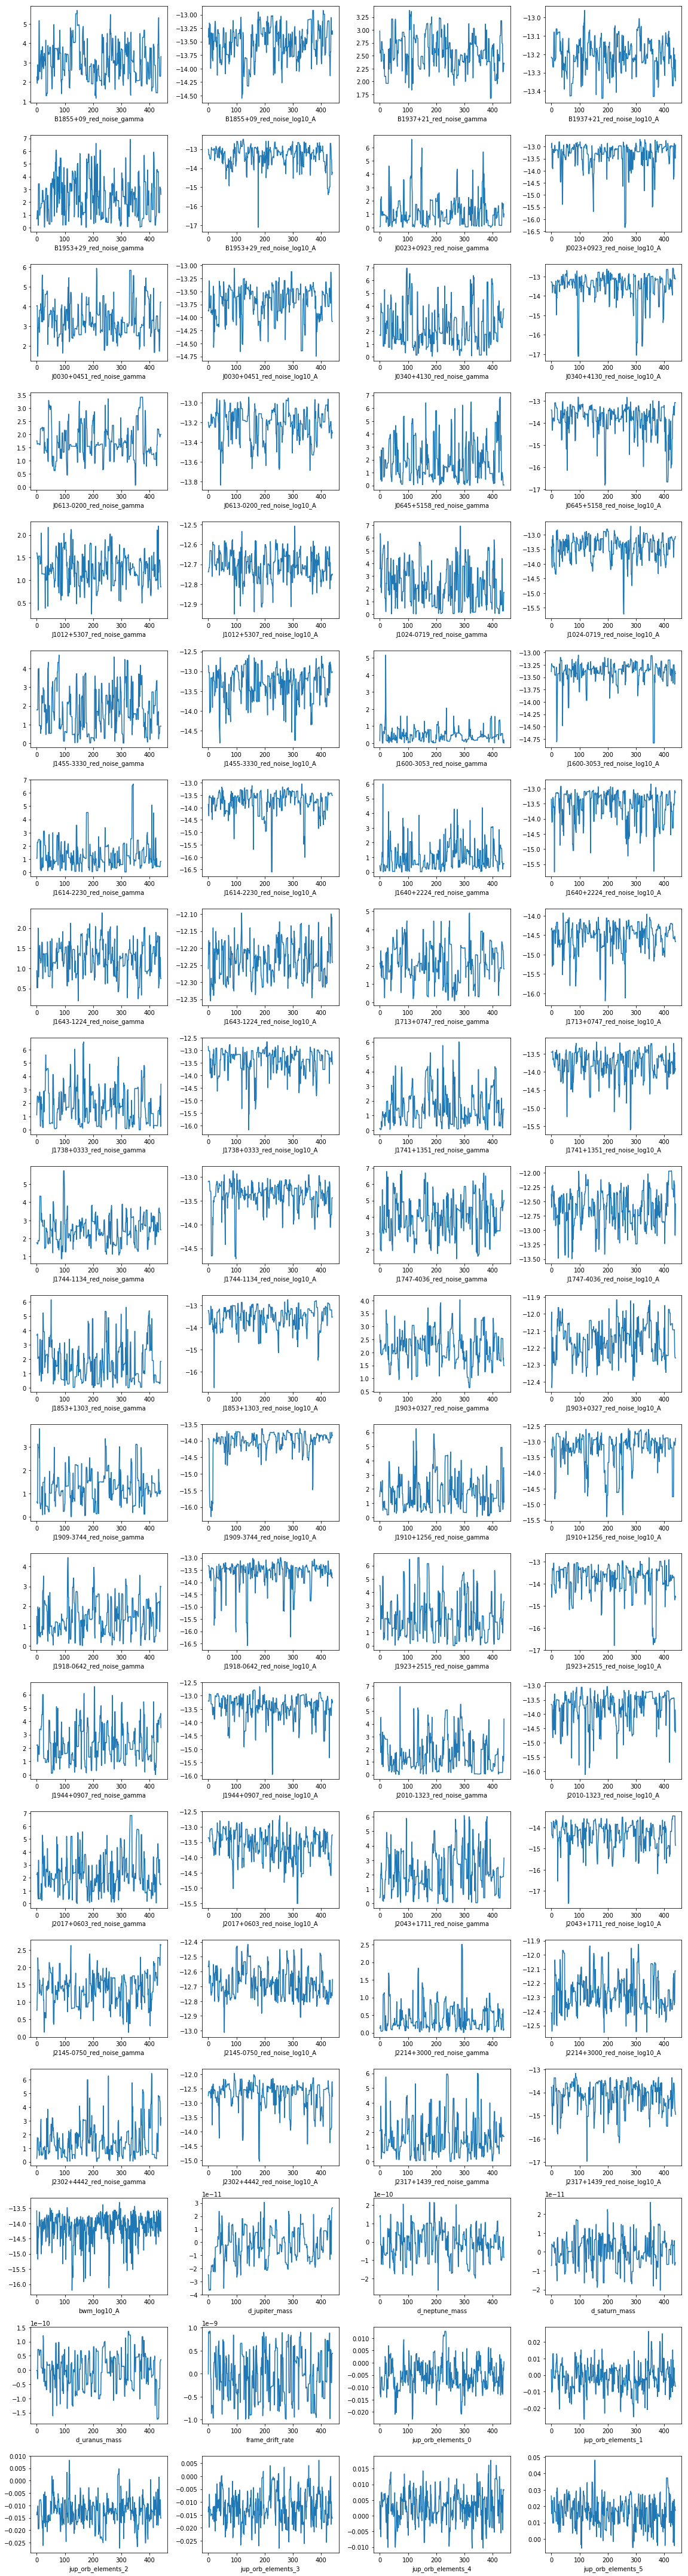

In [13]:
trace_plot(chain, params, cols=4);

# combining all samples into a new chain

In [38]:
UL_dict = {}

In [97]:
Nsamp = 100

burnfrac = 0.15
thin = 1

eph = 'DE436'
bayesephem = True
eph += '_BE' if bayesephem else ''

runroot = '/home/pbaker/nanograv/bwm/ULvT/{0:s}/{1:.2f}/{2:02d}/{3:.2f}/'

nside = 2
Npix = hp.nside2npix(nside)  # 48 sky points

Npol = 8  # number of polarization bins
POLs = np.arange(Npol) * np.pi / Npol

Nts = 40  # number of time bins
TMIN = 53217.0
TMAX = 57387.0
Ts_all = np.linspace(TMIN, TMAX, Nts+2)[1:-1]  # don't use first/last t0

In [98]:
Ts = Ts_all

resamp = {}
ULs = {}
bad = []
for t0 in Ts:
    resamp[t0] = []
    ULs[t0] = []
    print("working on {:.2f}".format(t0))
    
    for sky in range(Npix):
        for psi in POLs:
            rundir = runroot.format(eph, t0, sky, psi)
            chfile = os.path.join(rundir, 'chain_1.txt')
            try:
                chain_raw = pd.read_csv(chfile, sep='\t',
                                        dtype=float, header=None).values
                burn = int(burnfrac * len(chain_raw))
                ch = chain_raw[burn::thin, :-4]  # parameter values
                ULs[t0].append(UL_subsamp(ch[:, idx_A])[0])

                N = len(ch)
                idx = np.random.choice(range(N), size=Nsamp).flat
                resamp[t0].append(ch[idx])
            except:
                ULs[t0].append(np.nan)
                bad.append((t0, sky, psi))

working on 53318.71
working on 53420.41
working on 53522.12
working on 53623.83
working on 53725.54
working on 53827.24
working on 53928.95
working on 54030.66
working on 54132.37
working on 54234.07
working on 54335.78
working on 54437.49
working on 54539.20
working on 54640.90
working on 54742.61
working on 54844.32
working on 54946.02
working on 55047.73
working on 55149.44
working on 55251.15
working on 55352.85
working on 55454.56
working on 55556.27
working on 55657.98
working on 55759.68
working on 55861.39
working on 55963.10
working on 56064.80
working on 56166.51
working on 56268.22
working on 56369.93
working on 56471.63
working on 56573.34
working on 56675.05
working on 56776.76
working on 56878.46
working on 56980.17
working on 57081.88
working on 57183.59
working on 57285.29


In [99]:
len(bad)

0

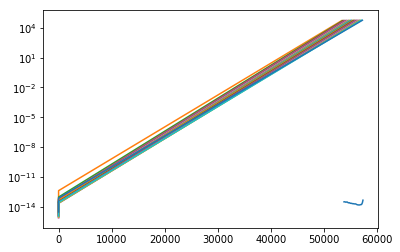

In [100]:
plt.plot(*ULave)
plt.plot(*ULmarg.T[:])
plt.yscale('log')

In [172]:
ULmarg = [[t0, *UL_subsamp(10**np.vstack(resamp[t0])[:,idx_A], p=0.95, Ntrial=20)]
           for t0 in Ts if len(resamp[t0])>1]

In [174]:
UL_dict[eph] = ULmarg
with open('/home/pbaker/nanograv/bwm/ULvT/ULs.json', 'w') as fout:
    json.dump(UL_dict, fout, sort_keys=True, indent=4, separators=(',', ': '))

t0 = 54335.78
resamp 5.659e-14


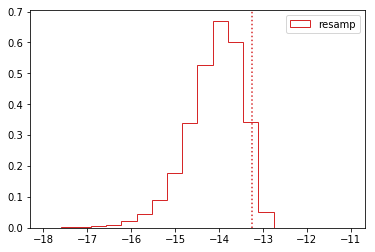

In [122]:
tt = 10
print('t0 = {:.2f}'.format(Ts[tt]))

new_ch = np.vstack(resamp[Ts[tt]])

UL, dUL = UL_subsamp(new_ch[:, idx_A])
print('resamp {:.3e}'.format(ULmarg[tt][1]))
#print('skyave {:.3e}'.format(ULave[1,tt]))

plt.hist(new_ch[:, idx_A], bins=20, histtype='step', density=True, label='resamp', color='C3');
plt.axvline(x=UL, ls=':', color='C3')
plt.legend()

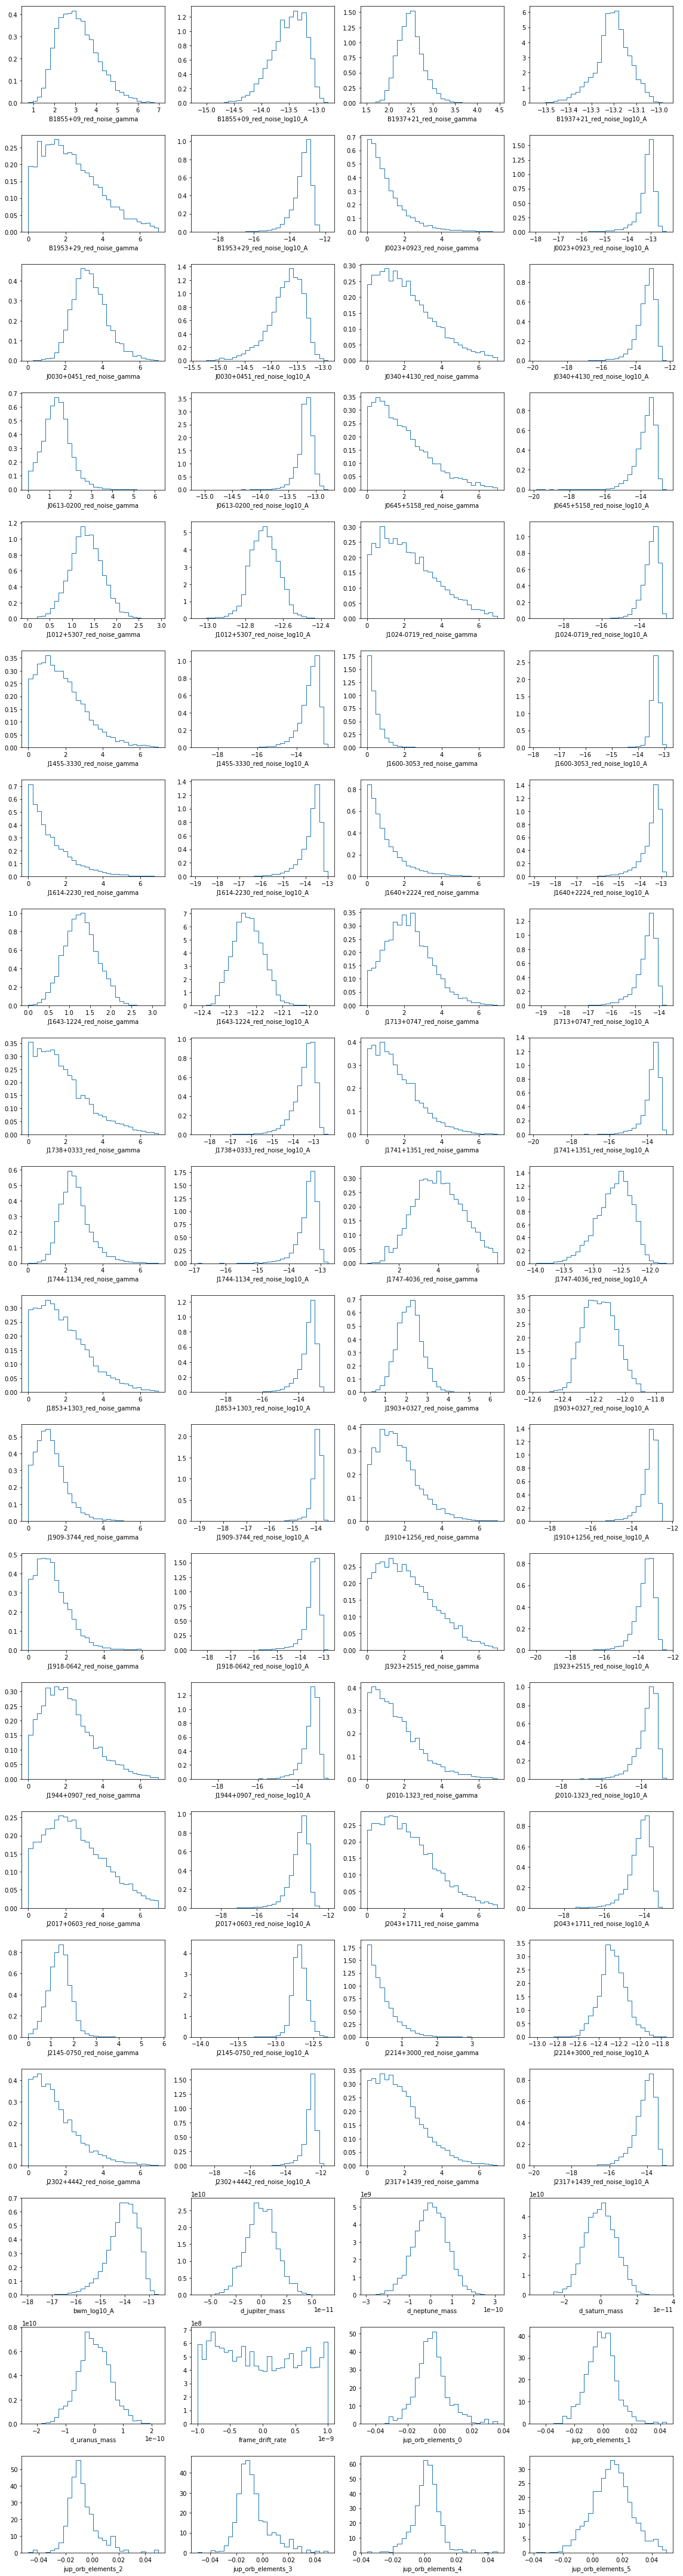

In [32]:
hist_plot(new_ch, params, cols=4);

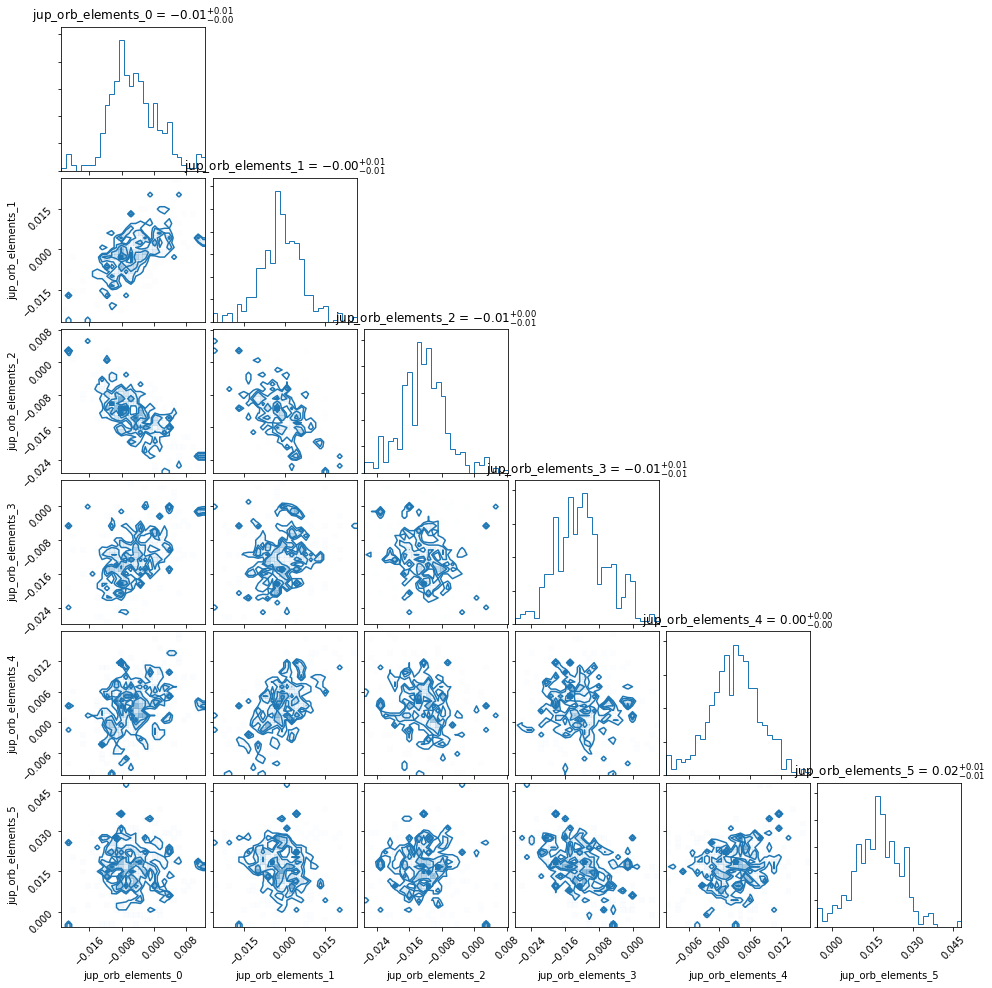

In [33]:
corner_kwargs = {'bins':30,
                 'show_titles':True,
                 'labels':par_jup,
                 'smooth':0.25,
                 'plot_datapoints':False,
                 'plot_density':True,
                 'plot_contours':True,
                 'fill_contours':False,}

fig = corner(chain[:,idx_jup], color='C0', **corner_kwargs);

# compare to J1713's sngl limit

In [123]:
sngl_runs = '/home/pbaker/nanograv/bwm/sngl/uplim_DE436'
pname = 'J1713+0747'

ULfile = os.path.join(sngl_runs, pname, "ULvT_{:s}.dat".format(pname))
UL_sngl = np.loadtxt(ULfile)

T_J1713 = Time(UL_sngl[0], format='mjd').decimalyear

J1713_UL = T_J1713, UL_sngl[1]*np.pi
J1713_opt = T_J1713, UL_sngl[1]

In [152]:
np.array(ULmarg).T[:2,:]

array([[5.33187073e+04, 5.34204146e+04, 5.35221220e+04, 5.36238293e+04,
        5.37255366e+04, 5.38272439e+04, 5.39289512e+04, 5.40306585e+04,
        5.41323659e+04, 5.42340732e+04, 5.43357805e+04, 5.44374878e+04,
        5.45391951e+04, 5.46409024e+04, 5.47426098e+04, 5.48443171e+04,
        5.49460244e+04, 5.50477317e+04, 5.51494390e+04, 5.52511463e+04,
        5.53528537e+04, 5.54545610e+04, 5.55562683e+04, 5.56579756e+04,
        5.57596829e+04, 5.58613902e+04, 5.59630976e+04, 5.60648049e+04,
        5.61665122e+04, 5.62682195e+04, 5.63699268e+04, 5.64716341e+04,
        5.65733415e+04, 5.66750488e+04, 5.67767561e+04, 5.68784634e+04,
        5.69801707e+04, 5.70818780e+04, 5.71835854e+04, 5.72852927e+04],
       [1.32463333e-12, 4.17098752e-13, 1.50075600e-13, 9.59307614e-14,
        7.15265359e-14, 6.40063999e-14, 6.42819074e-14, 6.03864744e-14,
        5.71757419e-14, 5.82163844e-14, 5.65940528e-14, 4.90608960e-14,
        4.49812800e-14, 4.38401749e-14, 4.28708977e-14, 3.97944

In [153]:
best = 10**np.array([np.nanmin(ULs[t0]) for t0 in Ts])
worst = 10**np.array([np.nanmax(ULs[t0]) for t0 in Ts])

ULmarg = np.array(ULmarg).T[:2,:]

Ts_yr = Time(Ts, format='mjd').decimalyear
ULmarg[0] = Time(ULmarg[0], format='mjd').decimalyear

In [178]:
best

array([1.44490506e-13, 6.22070408e-14, 2.19012534e-14, 1.51206219e-14,
       1.28900134e-14, 6.88746799e-15, 7.46864473e-15, 7.78535327e-15,
       4.71788123e-15, 5.57351006e-15, 5.75463446e-15, 6.61798374e-15,
       5.38088219e-15, 5.22685056e-15, 5.15507171e-15, 5.10055013e-15,
       5.84093593e-15, 4.13696718e-15, 5.07611726e-15, 4.18810852e-15,
       4.16668178e-15, 4.22520830e-15, 3.68823550e-15, 3.79931560e-15,
       4.01828926e-15, 4.47221972e-15, 2.99191590e-15, 4.93018684e-15,
       3.48198989e-15, 4.19956015e-15, 2.53736492e-15, 4.12775499e-15,
       3.85474276e-15, 3.03049650e-15, 4.43941884e-15, 4.21373834e-15,
       5.21945653e-15, 5.32721146e-15, 8.77647508e-15, 1.31618897e-14])

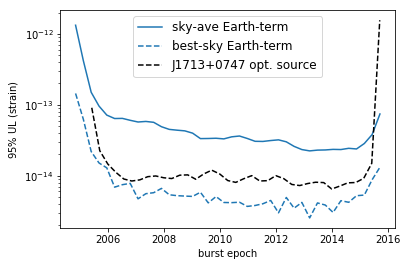

In [154]:
plt.close()

plt.close()
fig = plt.figure(figsize=(5,3))

#plt.plot(*ULave, color='C0', label="sky-ave Earth-term")
plt.plot(*ULmarg, color='C0', label="sky-ave Earth-term")

plt.plot(Ts_yr, best, ls='--', color='C0', label="best-sky Earth-term")
#plt.plot(Ts_yr, worst, ls=':', color='C0', label="worst-sky Earth-term")

#plt.plot(*J1713_UL, color='k', label=pname+" sky-ave")
plt.plot(*J1713_opt, ls='--', color='k', label=pname+" opt. source")

plt.legend(loc='upper center', fontsize=12)
plt.yscale('log')
plt.xlabel(r'burst epoch')
plt.ylabel(r'$95\%$ UL (strain)');

plt.tight_layout()
plt.savefig("/home/pbaker/UL_v_t_compare.pdf")

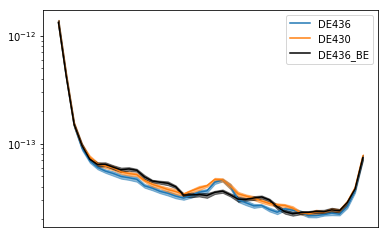

In [177]:
colors = ['C0', 'C1', 'k']
for (key, val), col in zip(UL_dict.items(), colors):
    ts = Time([v[0] for v in val], format='mjd').decimalyear
    high = [v[1] + v[2] for v in val]
    low = [v[1] - v[2] for v in val]
    UL = [v[1] for v in val]
    plt.fill_between(ts, high, low, color=col, alpha=0.5)
    plt.plot(ts, UL, color=col, label=key)
plt.yscale('log')
plt.xscale('log')
plt.legend()

In [175]:
key = 'DE436_BE'
val = UL_dict[key]
ts = Time([v[0] for v in val], format='mjd').decimalyear
print(ts[5])

2006.2499832943536


In [165]:
ts

array([2004.85712382, 2005.13538256, 2005.41403274, 2005.69268293,
       2005.97133311, 2006.24998329, 2006.52863348, 2006.80728366,
       2007.08593385, 2007.36458403, 2007.64323421, 2007.9218844 ,
       2008.19998667, 2008.47787552, 2008.75576436, 2009.03374541,
       2009.31239559, 2009.59104577, 2009.86969596, 2010.14834614,
       2010.42699632, 2010.70564651, 2010.98429669, 2011.26294688,
       2011.54159706, 2011.82024724, 2012.09862722, 2012.37651606,
       2012.6544049 , 2012.93229375, 2013.21075844, 2013.48940862,
       2013.7680588 , 2014.04670899, 2014.32535917, 2014.60400936,
       2014.88265954, 2015.16130972, 2015.43995991, 2015.71861009])